In [1]:
%pylab inline
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import scipy.optimize as opt


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Progress bar function
def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [3]:
# First we import the different dataframes created from the analysis protocols and also the behavioral data
if sys.platform=='win32':
        os.chdir("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingMOCS\MainExperiment\Data")
elif sys.platform=='linux':
    os.chdir("/home/coateslab/LabData/TSLO_Experiment/CrowdingMOCS/TSLO_videos/crowding_microsaccade/")
saccData=pd.read_csv('saccDataTrial.csv')
behavData=pd.read_csv("behavData.csv")
questDF=pd.read_csv('questDF.csv')
# eyepos=pd.read_pickle("eyeposTrial.pkl")
driftData=pd.read_csv("driftDataTrial.csv")
stimData=pd.read_csv("stimData.csv")
leftVrightData_filtered=pd.read_csv("leftVrightData.csv")
# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that
# are below 0
saccData['DirectionPolar']=0
for i in range(len(saccData)):
    if saccData['Direction'].iloc[i]<0:
        saccData['DirectionPolar'].iloc[i]=saccData['Direction'].iloc[i]+360
    else:
        saccData['DirectionPolar'].iloc[i]=saccData['Direction'].iloc[i]


C:\Users\krish\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Pre-process dataframe:

First we clean up the raw dataframes and merge the saccade and behavioral dataframe on a trial by trial basis

In [4]:
# This cell preps the behav & microsaccade df to be able to merge them later
behavDataCode=behavData['code'].unique()
newBehavData=[]
for acode in behavDataCode:
    tempBehavData=behavData.query("code==@acode")
    trialList=np.arange(1,51,1)
    tempBehavData['ntrial']=trialList
    newBehavData.append(tempBehavData)
behavData=pd.concat(newBehavData)

def row_to_code(x):
    return "%s_%s"%(x.code,x.ntrial)
behavData['trialCode']=(behavData.apply(row_to_code,1)).astype(str)

def row_to_code_stimData(x):
    return "%s_%s"%(x.code,int(x.ntrial))
stimData['trialCode']=(stimData.apply(row_to_code_stimData,1).astype(str))

codeList=behavData['trialCode'].unique()
markerSacc=[]
for acode in codeList:
    stimulusOnset=stimData.query("trialCode==@acode")['stimulusOnsetTime'].values
    stimTime=stimulusOnset
    tempSacc=saccData.query("trialCode==@acode")
    tempSacc['relOnsetTime']=tempSacc['onsetTime']-stimTime
    tempSacc['reOffsetTime']=tempSacc['offsetTime']-stimTime
    tempSacc['relStimTime']=stimTime-tempSacc['onsetTime']
    markerSacc.append(tempSacc)
markerSacc=pd.concat(markerSacc)
markerSaccMerge=pd.merge(markerSacc,behavData,left_on='trialCode',right_on='trialCode')

# here we segregate the microsaccade data based on whether they were leftward or rightward.
# Criterion is based on Baumeler et al. 2020
# Krish June 21': Modified this to include only saccades 45° away from horizontal meridian
rightupSacc=markerSaccMerge.query("DirectionPolar<45 ")
rightdownSacc=markerSaccMerge.query("(DirectionPolar>315)")
rightwardSacc=rightupSacc.append(rightdownSacc)
# Here we flip what we call left & right since the eye traces from the algorithm are flipped
rightwardSacc['leftVright']='right'
leftwardSacc=markerSaccMerge.query("(DirectionPolar>135) & (DirectionPolar<225)")
leftwardSacc['leftVright']='left'
leftVrightData=leftwardSacc.append(rightwardSacc)     
leftVrightData['congruent']= np.where((leftVrightData['stim_loc'] == leftVrightData['leftVright']),1 ,0)
leftVrightData['ecc_cond']=np.where((leftVrightData['ecc']>3),'peripheral','parafoveal')
leftVrightData['spacing_cond']=np.where((leftVrightData['spacing']<=3),'close','far')

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

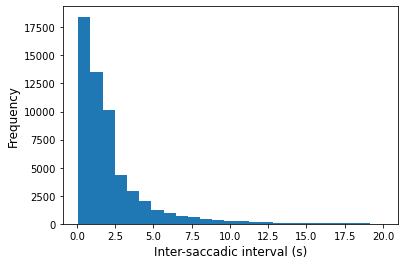

In [9]:
df=leftVrightData.groupby(['code_x'])['onsetTime'].diff().reset_index()
df.query("0<onsetTime<20")['onsetTime'].plot(kind='hist',bins=25)
plt.xlabel("Inter-saccadic interval (s)", size=12)
plt.ylabel("Frequency",size=12)
plt.savefig("InterSaccadicInterval_distribution.svg",dpi=1200,bbox_inches='tight')

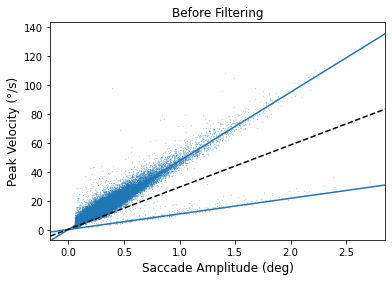

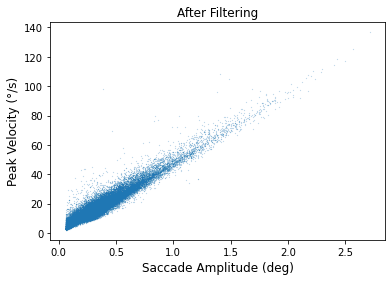

In [6]:
# We filter saccade events from every trial
# 1. Only use saccade events with Duration>15 ms and Duration<80ms 
# 2. We use events that have inter saccadic interval that is greater than 200 ms
# 3. We also filter data to use samples that fall on the main sequence/remove outliers(artifacts from saccade detectio method)
leftVrightData=leftVrightData.query("0.015<Duration<0.080")

# only use trials that have inter saccadic latency that is greater than 200 ms
df=leftVrightData.groupby(['code_x'])['onsetTime'].diff().reset_index()
df_filtered=df.query("0<onsetTime<0.200")
# We remove both events that are close together in time
index_array=df_filtered['index'].values
prev_index_array=index_array-1
combined_index_array=np.append(index_array,prev_index_array)
leftVrightData_filtered=leftVrightData.drop(combined_index_array,axis=0)

#Only use samples that fall along the main sequence plot and show linear relationship
x=(leftVrightData_filtered.VectorAmp.values)
y=(leftVrightData_filtered.peakVel.values)
# First get edges from histogram
num_bins=150
counts, yedges, xedges = np.histogram2d(y, x, bins=150)
# counts, yedges, xedges = np.histogram2d(y, x, bins=num_bins,range=[[0,np.max(y)], [0,np.max(x)]])
#Hough transform
from skimage.transform import hough_line, hough_line_peaks
h, theta, d = hough_line(counts)
#Plot output
plt.figure()
plt.scatter(x, y,s=.01)
#line x & y values
x_vals=[]
y_vals=[]
slope_vals=[]
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (y0,x0) = dist * np.array([np.cos(angle), np.sin(angle)])

    orig_slope=np.tan(angle + np.pi/2)
    new_x0=x0/num_bins*(xedges[-2])
    new_y0=y0/num_bins*(yedges[-2])
    new_slope=orig_slope*(np.max(yedges)/np.max(xedges))
    plt.axline((new_x0, new_y0), slope=new_slope)
    x_vals.append(new_x0)
    y_vals.append(new_y0)
    slope_vals.append(new_slope)
# We get the mid-point
x_mid=np.sum(x_vals)/2
y_mid=np.sum(y_vals)/2
slope_mid=np.sum(slope_vals)/2
# we draw line in between
plt.axline((x_mid,y_mid),slope=slope_mid,color='k',ls='--')

plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title('Before Filtering')

plt.figure()
below_line=y>(slope_mid*x)
x_filtered=x[below_line]
y_filtered=y[below_line]
plt.scatter(x_filtered,y_filtered,s=.01)
# Also get rejected data which we can also use to plot
below_line=y<(slope_mid*x)
x_reject=x[below_line]
y_reject=y[below_line]
plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title("After Filtering")

#Finally we tweak the saccade dataframe to use the filtered values
leftVrightData=leftVrightData_filtered.loc[leftVrightData_filtered['VectorAmp'].isin(x_filtered)]
leftVrightData_rejected=leftVrightData_filtered.loc[leftVrightData_filtered['VectorAmp'].isin(x_reject)]

In [11]:
df1=leftVrightData_filtered.query("-0.8<relOnsetTime<0.8")
df2=leftVrightData.query("-0.8<relOnsetTime<0.8")
len(df1),len(df2),(len(df2)-len(df1))/len(df2)*100

(35806, 36622, 2.2281688602479384)

In [10]:
df=leftVrightData_filtered.query("-0.8<relOnsetTime<0.8").groupby('trialCode')['Duration'].count().reset_index()
single_microsaccade_code=list(df.query("Duration==1")['trialCode'])
single_microsaccade_df=leftVrightData_filtered.query('-0.8<relOnsetTime<0.8 & trialCode==@single_microsaccade_code')

multiple_microsaccade_code=list(df.query("Duration>1")['trialCode'])
multiple_microsaccade_df=leftVrightData_filtered.query('-0.8<relOnsetTime<0.8 & trialCode==@multiple_microsaccade_code')
multiple_microsaccade_df.to_csv('multiple_microsaccade_df.csv')

In [14]:
df=leftVrightData.query("-0.8<relOnsetTime<0.8")
df.to_csv("leftVrightData.csv")

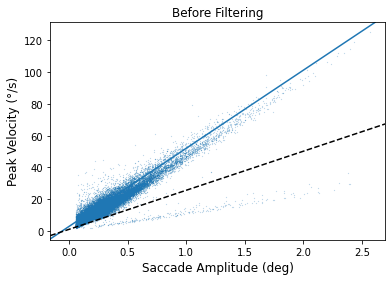

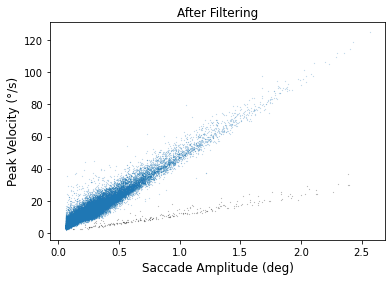

In [7]:
# We filter saccade events from every trial
# 1. Only use saccade events with Duration>15 ms and Duration<80ms 
# 2. We use events that have inter saccadic interval that is greater than 200 ms
# 3. We also filter data to use samples that fall on the main sequence/remove outliers(artifacts from saccade detectio method)
markerSaccMerge=markerSaccMerge.query("0.015<Duration<0.080")

# only use trials that have inter saccadic latency that is greater than 200 ms
df=markerSaccMerge.groupby(['code_x'])['onsetTime'].diff().reset_index()
df_filtered=df.query("0<onsetTime<0.200")
# We remove both events that are close together in time
index_array=df_filtered['index'].values
prev_index_array=index_array-1
combined_index_array=np.append(index_array,prev_index_array)
markerSaccMerge_filtered=markerSaccMerge.drop(combined_index_array,axis=0)

#Only use samples that fall along the main sequence plot and show linear relationship
x=(markerSaccMerge_filtered.VectorAmp.values)
y=(markerSaccMerge_filtered.peakVel.values)
# First get edges from histogram
num_bins=150
counts, yedges, xedges = np.histogram2d(y, x, bins=150)
# counts, yedges, xedges = np.histogram2d(y, x, bins=num_bins,range=[[0,np.max(y)], [0,np.max(x)]])
#Hough transform
from skimage.transform import hough_line, hough_line_peaks
h, theta, d = hough_line(counts)
#Plot output
plt.figure()
plt.scatter(x, y,s=.01)
#line x & y values
x_vals=[]
y_vals=[]
slope_vals=[]
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (y0,x0) = dist * np.array([np.cos(angle), np.sin(angle)])

    orig_slope=np.tan(angle + np.pi/2)
    new_x0=x0/num_bins*(xedges[-2])
    new_y0=y0/num_bins*(yedges[-2])
    new_slope=orig_slope*(np.max(yedges)/np.max(xedges))
    plt.axline((new_x0, new_y0), slope=new_slope)
    x_vals.append(new_x0)
    y_vals.append(new_y0)
    slope_vals.append(new_slope)
# We get the mid-point
x_mid=np.sum(x_vals)/2
y_mid=np.sum(y_vals)/2
slope_mid=np.sum(slope_vals)/2
# we draw line in between
plt.axline((x_mid,y_mid),slope=slope_mid,color='k',ls='--')

plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title('Before Filtering')

plt.figure()
above_line=y>(slope_mid*x)
x_filtered=x[above_line]
y_filtered=y[above_line]
plt.scatter(x_filtered,y_filtered,s=.01)
# Also get rejected data which we can also use to plot
below_line=y<(slope_mid*x)
x_reject=x[below_line]
y_reject=y[below_line]
plt.scatter(x_reject,y_reject,s=.01,color='k')
plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title("After Filtering")

#Finally we tweak the saccade dataframe to use the filtered values
markerSaccMerge_filtered=markerSaccMerge_filtered.loc[markerSaccMerge_filtered['VectorAmp'].isin(x_filtered)]
markerSaccMerge_reject=markerSaccMerge_filtered.loc[markerSaccMerge_filtered['VectorAmp'].isin(x_reject)]

In [26]:
mydata['VectorAmp'].median()

0.2521676553221076

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


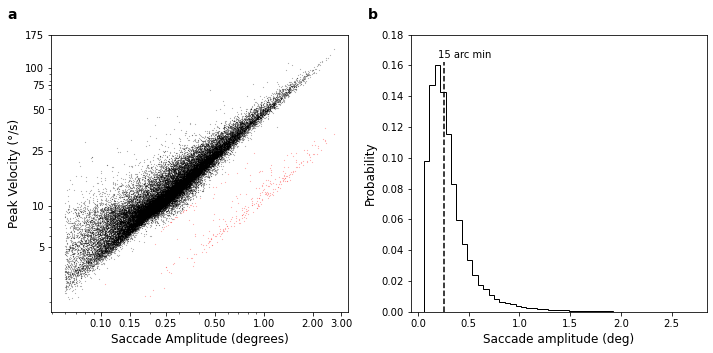

In [7]:
#TODO sns plot by subject
# plt.figure(figsize=(20,10))
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
counter=0
for col in ax:
    if counter==0:
        mydata=leftVrightData.query("-0.800<relOnsetTime<0.800")
        mydata['AmpArcMin']=mydata['VectorAmp']*60
        col.scatter(mydata['VectorAmp'],mydata['peakVel'],marker='.',s=0.05,color='k')
        # Also plot the rejected data
        data_rejected=leftVrightData_rejected.query("-0.800<relOnsetTime<0.800")
        data_rejected['AmpArcMin']=data_rejected['VectorAmp']*60
        col.scatter(data_rejected['VectorAmp'],data_rejected['peakVel'],marker='.',s=0.05,color='r')
        # sns.lmplot(x="AmpArcMin",y="peakVel",data=mydata,fit_reg=False,markers='o', scatter_kws={"s": 0.05,"color":'k'})
        col.set_xlabel('Saccade Amplitude (degrees)',size=12)
        col.set_ylabel('Peak Velocity (°/s)',size=12)
        # plt.ylim(0,30)
        col.set_xscale('log')
        col.set_xticks([0.1,0.15,0.25,0.5,1, 2,3])
        col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        col.set_yscale('log')
        col.set_yticks([5,10,25,50,75, 100,175])
        col.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        col.text(0.0265,227.5,r'$\bf{a}$',size=14)
    else:
        weights = np.ones_like(mydata['VectorAmp'])/float(len(mydata['VectorAmp']))
        col.hist((mydata['VectorAmp']),bins=50,histtype='step',color='k',weights=weights)
        col.set_xlabel('Saccade amplitude (deg)',size=12)
        col.set_ylabel('Probability',size=12)
        col.axvline(x=mydata['VectorAmp'].median(),ymin=0,ymax=0.9,ls='--',color='k')
        col.text(mydata['VectorAmp'].median()-0.05,0.165,"15 arc min")
        plt.ylim(0,0.18)
        col.text(-0.5,0.19,r"$\bf{b}$",size=14)
    counter+=1
fig.tight_layout()
plt.savefig('..\Plots\MainSeqPlot_ArcMin&SaccadeAmplitudeWRejectedData.pdf',dpi=1200,bbox_tight=True)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


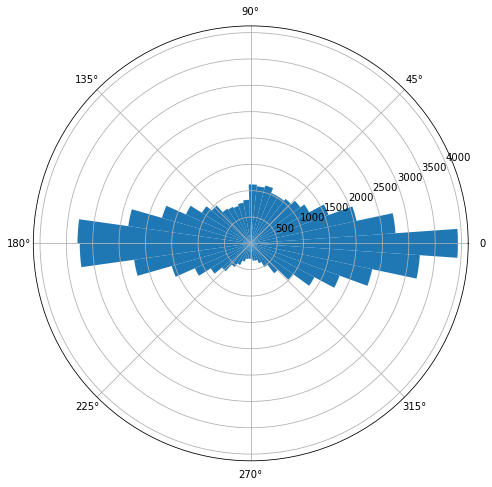

In [19]:
# two input arrays
data=markerSaccMerge_filtered#.query("s & 0<relOnsetTime<0.200")
arr=np.radians(data['DirectionPolar'])
# radius=data['VectorAmp']*60


N = 45
bottom = 2

# create theta for 24 hours
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
radii, tick = np.histogram(arr, bins = N)

# width of each bin on the plot
width = (2*np.pi) / N

# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# set the lable go clockwise and start from the top
ax.set_theta_zero_location("E")
# counter-clockwise
ax.set_theta_direction(1)

# set the label
ticks = ['0', '45°', '90°', '135°', '180°', '225°', '270°', '315°']
ax.set_xticklabels(ticks)

plotFilename=('..\Plots\MicrosaccadeDirectionDistribution_beforeFiltering.svg')
plt.savefig(plotFilename,bbox_tight= True,format='svg',dpi=1200)

## Behavioral Performance binning : Microsaccade

In [ ]:
#segregate by spacing
noSacc=pd.DataFrame({'binPt':[],'count':[],'meanPerf':[],'sdPerf':[],'spacing':[],'ecc':[],'subj':[]})
binSacc1=pd.DataFrame({'binPt':[],'count':[],'meanPerf':[],'sdPerf':[],'spacing':[],'ecc':[],'subj':[]})
binSacc2=pd.DataFrame({'binPt':[],'count':[],'meanPerf':[],'sdPerf':[],'spacing':[],'ecc':[],'subj':[]})
startPt=-0.200
endPt=0.500
bins=np.arange(startPt,endPt,0.001)
binSize=0.050
binWidth=binSize/2
spacings=leftVrightData['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
numelements=len(subs)*len(bins)*5*len(spacings)
counter=0
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        for ecc in range(1,6):
            for aspacing in spacings:
                update_progress(counter/numelements)
                #congruent Condition
                data=leftVrightData.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id==@asub & congruent==1")['corr']
                mean=data.mean()
                sd=data.std()
                count=data.count()
                binSacc1=binSacc1.append({'binPt':abin,'count':count,'meanPerf':mean,'sdPerf':sd,'spacing':aspacing,'ecc':ecc,'subj':asub},ignore_index=True)
                binSacc1['congruent']='Congruent'
                #incongruent Condition
                data=leftVrightData.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id==@asub & congruent==0")['corr']
                mean=data.mean()
                sd=data.std()
                count=data.count()
                binSacc2=binSacc2.append({'binPt':abin,'count':count,'meanPerf':mean,'sdPerf':sd,'spacing':aspacing,'ecc':ecc,'subj':asub},ignore_index=True)
                binSacc2['congruent']='Incongruent'
                counter+=1

saccBins=binSacc1.append(binSacc2)
saccBins['binWidth']=binSize
saccBins['ecc_cond']=np.where((saccBins['ecc']>3),'peripheral','parafoveal')
saccBins['spacing_cond']=np.where((saccBins['spacing']<=3),'close','far')

## Microsaccade Rate Binning

In [ ]:
# Microsaccade reaction time compution v stimulus onset time

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002 #seconds
binSize=0.100

#Main core of the binning protocol
startPt=-0.400
endPt=0.800
bins=np.arange(startPt,endPt,0.002)
binWidth=binSize/2
spacings=leftVrightData['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=leftVrightData['target'].unique()
responses=[1,0]
congruent=[1,0]
numelements=len(subs)*len(bins)*5*len(spacings)*len(responses)*len(nums)*len(congruent)
counter=0
# we create the necessary lists
binPtList=[]
countList=[]
spacingList=[]
eccList=[]
subList=[]
corrList=[]
targetList=[]
congruentList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        for ecc in range(1,6):
            for aresp in responses:
                for aspacing in spacings:
                    for anum in nums:
                        for congruent_cond in congruent:
                            update_progress(counter/numelements)
                            data=leftVrightData.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id==@asub & corr==@aresp & target==@anum & congruent==@congruent_cond")
                            count=len(data)
                            # now we append the values to respective lists
                            binPtList.append(abin)
                            countList.append(count)
                            spacingList.append(aspacing)
                            eccList.append(ecc)
                            corrList.append(aresp)
                            subList.append(asub)
                            targetList.append(anum)
                            congruentList.append(congruent_cond)
                            counter+=1
data=np.column_stack((binPtList,countList,spacingList,eccList,corrList,subList,targetList,congruentList))
RateBin=pd.DataFrame(data)
RateBin.columns=['binPt','Count','spacing','ecc','corr','subj_id','target','congruency']
RateBin['binPt']=RateBin['binPt'].astype(np.float16)
RateBin['Count']=RateBin['Count'].astype(np.float16)
RateBin['target']=RateBin['target'].astype(np.float16)
RateBin['ecc']=RateBin['ecc'].astype(int)
RateBin['spacing']=RateBin['spacing'].astype(np.float16)
RateBin['ecc_cond']=np.where((RateBin['ecc']>3),'peripheral','parafoveal')
RateBin['spacing_cond']=np.where((RateBin['spacing']<=3),'close','far')

# we finally save the df to a pickle file
RateBin.to_pickle('RateBin_%dmsStep_%dmsSize.pkl'%(stepSize,binSize))

## Reaction Time binning: Microsaccade

In [ ]:
# Microsaccade reaction time compution v stimulus onset time

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002 #seconds
binSize=0.075

startPt=-0.400
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=leftVrightData['target'].unique()
responses=[1,0]
numelements=len(subs)*len(bins)*5*len(spacings)*len(responses)*len(nums)
counter=0
# we create the necessary lists
binPtList=[]
RTList=[]
spacingList=[]
eccList=[]
subList=[]
corrList=[]
targetList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        for ecc in range(1,6):
            for aresp in responses:
                for aspacing in spacings:
                    for anum in nums:
                        #congruent Condition
                        update_progress(counter/numelements)
                        data=leftVrightData.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id==@asub & corr==@aresp & target==@anum")['RT']
                        RT=data.mean()
                        sd=data.std()
                        count=data.count()
                        binPtList.append(abin)
                        RTList.append(RT)
                        spacingList.append(aspacing)
                        eccList.append(ecc)
                        corrList.append(aresp)
                        subList.append(asub)
                        targetList.append(anum)
                        counter+=1
data=np.column_stack((binPtList,RTList,spacingList,eccList,corrList,subList,targetList))
RTBin=pd.DataFrame(data)
RTBin.columns=['binPt','RT','spacing','ecc','corr','subj_id','target']
RTBin['binPt']=RTBin['binPt'].astype(np.float16)
RTBin['RT']=RTBin['RT'].astype(np.float16)
RTBin['target']=RTBin['target'].astype(np.float16)
RTBin['ecc']=RTBin['ecc'].astype(int)
RTBin['spacing']=RTBin['spacing'].astype(np.float16)
RTBin['ecc_cond']=np.where((RTBin['ecc']>3),'peripheral','parafoveal')
RTBin['spacing_cond']=np.where((RTBin['spacing']<=3),'close','far')

# we finally save the df to a pickle 
RTBin.to_pickle('RTBins_%dmsStep_%dmsSize.pkl'%(stepSize,binSize))


## Microsaccade direction binning

In [ ]:
# Microsaccade direction based on congruency with stimulus location

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002 #seconds
binSize=0.075

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=leftVrightData['target'].unique()
responses=[1,0]
numelements=len(subs)*len(bins)*5*len(spacings)*len(responses)*len(nums)
counter=0
# we create the necessary lists
binPtList=[]
propCongList=[]
spacingList=[]
eccList=[]
subList=[]
corrList=[]
targetList=[]

for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        for ecc in range(1,6):
            for aspacing in spacings:
                for aresp in responses:
                    for anum in nums:
                        update_progress(counter/numelements)
                        #congruent Condition
                        data=leftVrightData.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id==@asub & corr==@aresp & target==@anum")
                        numCong=len(data.query("congruent==1"))
                        numTrial=len(data)
                        if numTrial==0:
                            propCong=np.nan
                        else:
                            propCong=numCong/numTrial
                        binPtList.append(abin)
                        propCongList.append(propCong)
                        spacingList.append(aspacing)
                        eccList.append(ecc)
                        corrList.append(aresp)
                        subList.append(asub)
                        targetList.append(anum)
                        counter+=1
data=np.column_stack((binPtList,propCongList,spacingList,eccList,corrList,subList,targetList))
dirBin=pd.DataFrame(data)
dirBin.columns=['binPt','propCong','spacing','ecc','corr','subj_id','target']
dirBin['binPt']=dirBin['binPt'].astype(np.float16)
dirBin['propCong']=dirBin['propCong'].astype(np.float16)
dirBin['target']=dirBin['target'].astype(np.float16)
dirBin['ecc']=dirBin['ecc'].astype(int)
dirBin['spacing']=dirBin['spacing'].astype(np.float16)
dirBin['ecc_cond']=np.where((dirBin['ecc']>3),'peripheral','parafoveal')
dirBin['spacing_cond']=np.where((dirBin['spacing']<=3),'close','far')

# we finally save the df to a pickle file
dirBin.to_pickle('dirBins_%dmsStep_%dmsSize.pkl'%(stepSize,binSize))

## Microsaccade Amplitude binning 

In [ ]:
# Microsaccade amplitude as  function of stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002 #seconds
binSize=0.075

startPt=-0.400
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData['spacing'].unique()
subs=['S01','S02','S03']
responses=[1,0]
nums=leftVrightData['target'].unique()
numelements=len(subs)*len(bins)*5*len(spacings)*len(responses)*len(nums)
counter=0
# we create the necessary lists
binPtList=[]
AmpList=[]
spacingList=[]
eccList=[]
subList=[]
corrList=[]
targetList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        for ecc in range(1,6):
            for aspacing in spacings:
                for aresp in responses:
                    for anum in nums:
                        update_progress(counter/numelements)
                        #congruent Condition
                        data=leftVrightData.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id==@asub & corr==@aresp &target==@anum")
                        numTrial=len(data)
                        if numTrial==0:
                            AmpVal=np.nan
                        else:
                            AmpVal=data['VectorAmp'].mean()
                        binPtList.append(abin)
                        AmpList.append(AmpVal)
                        spacingList.append(aspacing)
                        eccList.append(ecc)
                        corrList.append(aresp)
                        subList.append(asub)
                        targetList.append(anum)
                        counter+=1
data=np.column_stack((binPtList,AmpList,spacingList,eccList,corrList,subList,targetList))
ampBin=pd.DataFrame(data)
ampBin.columns=['binPt','AmpVal','spacing','ecc','corr','subj_id','target']
ampBin['binPt']=ampBin['binPt'].astype(np.float16)
ampBin['AmpVal']=ampBin['AmpVal'].astype(np.float16)
ampBin['target']=ampBin['target'].astype(np.float16)
ampBin['ecc']=ampBin['ecc'].astype(int)
ampBin['spacing']=ampBin['spacing'].astype(np.float16)
ampBin['ecc_cond']=np.where((ampBin['ecc']>3),'peripheral','parafoveal')
ampBin['spacing_cond']=np.where((ampBin['spacing']<=3),'close','far')

# we finally save the df to a pickle file
ampBin=pd.read_pickle('AmpBin_%dmsStep_%dmsSize.pkl'%(stepSize,binSize))

## Microsaccade binning method: Combined


In [23]:
# Identify trials without microsaccade
trialWsaccList=leftVrightData_filtered['trialCode'].unique()
trialWOsaccList=behavData[~behavData.trialCode.isin(trialWsaccList)]['trialCode']
noSaccDF=behavData[~behavData.trialCode.isin(trialWsaccList)]

In [194]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002#seconds
binSize=0.200

startPt=-0.600
endPt=0.600
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData_filtered['spacing'].unique()
stim_locs=leftVrightData_filtered['stim_loc'].unique()
sacc_direction=leftVrightData_filtered['leftVright'].unique()
subs=['S01','S02','S03','S04','S05']
responses=[1,0]
nums=leftVrightData_filtered['target'].unique()
numelements=len(subs)*len(bins)*5*len(spacings)*len(responses)*len(nums)*len(stim_locs)*len(sacc_direction)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
binPtList=[]
spacingList=[]
stim_loc_list=[]
sacc_direction_list=[]
eccList=[]
subList=[]
corrList=[]
targetList=[]
#second we create lists for the outcome/microsaccade metrics
perfList=[]
RTList=[]
propCongList=[]
AmpList=[]
countList=[]

for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        for ecc in range(1,6):
            for aspacing in spacings:
                for anum in nums:
                    for astim in stim_locs:
                        for asaccdirection in sacc_direction:
                            # We add response as another condition when computing microsaccade metrics
                            for aresp in responses:
                                print('%d/%d'%(counter,numelements),end='\r')
                                saccDF=leftVrightData_filtered.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id_x==@asub & corr==@aresp &target==@anum & stim_loc==@astim & leftVright==@asaccdirection")
                                numTrial=len(saccDF)
                                #number of congruent microsaccades
                                numCong=len(saccDF.query("congruent==1")) 
                                # to prevent breaks we add nans when a query comes back empty
                                if numTrial==0: 
                                    RTVal=np.nan
                                    meanCorr=np.nan
                                    AmpVal=np.nan
                                    propCong=np.nan
                                else:
                                    # Compute RT 
                                    RTVal=saccDF['RT'].mean()
                                    # compute mean sacc amplitude
                                    AmpVal=saccDF['VectorAmp'].mean()
                                    # compute proportion congruent
                                    propCong=numCong/numTrial
                                # we append the experiment conditions
                                binPtList.append(abin)
                                spacingList.append(aspacing)
                                eccList.append(ecc)
                                corrList.append(aresp)
                                subList.append(asub)
                                targetList.append(anum)
                                stim_loc_list.append(astim)
                                sacc_direction_list.append(asaccdirection)
                                # finally append the microsaccade metric that was computed earlier
                                RTList.append(RTVal)
                                propCongList.append(propCong)
                                AmpList.append(AmpVal)
                                countList.append(numTrial)
                                # we increment counter
                                counter+=1
                        
# # we stack the independent lists together                        
dataWsacc=np.column_stack((binPtList,spacingList,eccList,corrList,subList,targetList,stim_loc_list,sacc_direction_list,RTList,propCongList,AmpList,countList))
# BinData=pd.DataFrame([binPtList,spacingList,eccList,corrList,subList,targetList,stim_loc_list,sacc_direction_list,RTList,propCongList,AmpList,countList])
BinData.columns=['binPt','spacing','ecc','corr','subj_id','target','stim_loc','leftVright','RT','propCong','AmpVal','Count']

# declare experiment condition variable type
BinData['binPt']=BinData['binPt'].astype(np.float16)
BinData['target']=BinData['target'].astype(np.float16)
BinData['ecc']=BinData['ecc'].astype(int)
BinData['spacing']=BinData['spacing'].astype(np.float16)

# declare microsaccade metric variable type
BinData['RT']=BinData['RT'].astype(np.float16)
BinData['propCong']=BinData['propCong'].astype(np.float16)
BinData['AmpVal']=BinData['AmpVal'].astype(np.float16)
BinData['Count']=BinData['Count'].astype(int)

#group data based on experiment condition
BinData['ecc_cond']=np.where((BinData['ecc']>3),'peripheral','parafoveal')
BinData['spacing_cond']=np.where((BinData['spacing']<=3),'close','far')

# #we then save the dataframes
BinData.to_pickle('BinnedData_%dmsStep_%dmsSize_finerTuning_Horz.pkl'%((stepSize*1000),(binSize*1000)))


KeyboardInterrupt: 

In [18]:
# Microsaccade metrics binned with respect to stimulus onset
# All microsaccade together
import warnings
warnings.filterwarnings("ignore")
# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002#seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData_filtered['spacing'].unique()
stim_locs=leftVrightData_filtered['stim_loc'].unique()
# nums=leftVrightData_filtered.target.uniqueftVright'].unique()
subs=['S01','S02','S03','S04','S05']
responses=[1,0]
congruencies=leftVrightData_filtered.congruent.unique()
nums=leftVrightData_filtered['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
BinData=[]

for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        print('%d/%d'%(counter,numelements),end='\r')
        tempDF=leftVrightData_filtered.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        tempDF['binPt']=abin
        BinData.append(tempDF)
        counter+=1

BinData=pd.concat(BinData)
# # #we then save the dataframes
BinData.to_pickle('BinnedData_%dmsStep_%dmsSize_finerTuning_Horz.pkl'%((stepSize*1000),(binSize*1000)))


In [19]:
# Microsaccade metrics binned with respect to stimulus onset
# Only using single microsaccades
import warnings
warnings.filterwarnings("ignore")
# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010#seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=single_microsaccade_df['spacing'].unique()
stim_locs=single_microsaccade_df['stim_loc'].unique()
# nums=leftVrightData_filtered.target.uniqueftVright'].unique()
subs=['S01','S02','S03','S04','S05']
responses=[1,0]
congruencies=single_microsaccade_df.congruent.unique()
nums=leftVrightData_filtered['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
BinData=[]

for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        print('%d/%d'%(counter,numelements),end='\r')
        tempDF=single_microsaccade_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        tempDF['binPt']=abin
        BinData.append(tempDF)
        counter+=1

BinData=pd.concat(BinData)
# # #we then save the dataframes
BinData.to_csv('BinnedData_single_microsaccade_%dmsStep_%dmsSize_finerTuning_Horz.csv'%((stepSize*1000),(binSize*1000)))


In [20]:
# Microsaccade metrics binned with respect to stimulus onset
# Only using single microsaccades
import warnings
warnings.filterwarnings("ignore")
# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010#seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=['S01','S02','S03','S04','S05']
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
BinData=[]

for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        print('%d/%d'%(counter,numelements),end='\r')
        tempDF=multiple_microsaccade_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        tempDF['binPt']=abin
        BinData.append(tempDF)
        counter+=1

BinData=pd.concat(BinData)
# # #we then save the dataframes
BinData.to_csv('BinnedData_multiple_microsaccades_%dmsStep_%dmsSize_finerTuning_Horz.csv'%((stepSize*1000),(binSize*1000)))


In [183]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002 #seconds
binSize=0.200

startPt=-0.600
endPt=0.600
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData_filtered['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=leftVrightData_filtered['target'].unique()
cong_conds=[0,1]
responses=[1,0]
numelements=len(subs)*len(bins)*5*len(spacings)*len(cong_conds)* len(responses)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
binPtListperf=[]
spacingListperf=[]
eccListperf=[]
subListperf=[]
targetListperf=[]
#second we create lists for the outcome/microsaccade metrics
perfList=[]
congList=[]
countList=[]
# No microsaccade condition list
perfListNoSacc=[]
for asub in subs:
    for ecc in range(1,6):
        for aspacing in spacings:
            for aresp in responses:
                for abin in bins:
                    start=abin-binWidth
                    end=abin+binWidth
                    for acong in cong_conds:
                        # Trials with microsaccades present
                        print('%d/%d'%(counter,numelements),end='\r')
                        perfDF=leftVrightData_filtered.query("@start<relOnsetTime<@end & spacing==@aspacing & ecc==@ecc & subj_id_x==@asub & congruent==@acong")
                        numTrial=len(perfDF)
                        if numTrial==0:
                            meanCorr=np.nan
                        else:
                            # Compute mean behavioral performance
                            meanCorr=perfDF['corr'].mean()  
                        perfList.append(meanCorr)
                        #Trials W/o microsaccades 
                        datanoSacc=noSaccDF.query("spacing==@aspacing & ecc==@ecc & subj_id==@asub")
                        numTrial=len(datanoSacc)
                        # to prevent breaks we add nans when a query comes back empty
                        if numTrial==0:
                            meanCorr=np.nan
                        else:
                            # Compute mean behavioral perforamnce
                            meanCorr=datanoSacc['corr'].mean()
                        # we add the metric to a separate list
                        perfListNoSacc.append(meanCorr)
                        # we append the experiment conditions
                        binPtListperf.append(abin)
                        spacingListperf.append(aspacing)
                        eccListperf.append(ecc)
                        subListperf.append(asub)
                        congList.append(acong)
                        counter+=1
                    
# We form the dataframe for the performance data
# First we run it for the ones with microsaccades present followed by ones without microsaccades
#Data with microsaccades
dataWsacc=np.column_stack((binPtListperf,spacingListperf,eccListperf,subListperf,congList,perfList))
BinDataSacc=pd.DataFrame(dataWsacc)
BinDataSacc.columns=['binPt','spacing','ecc','subj_id','congruent','meanPerf']
BinDataSacc['sacc_cond']='Sacc'
BinDataSacc['congruent']=BinDataSacc['congruent'].astype(int)
#Data with no microsaccades
# creat a dummy congruency list for the no microsaccade condition
congList=np.empty((len(spacingListperf),1))
congList[:]=np.nan
dataWOsacc=np.column_stack((binPtListperf,spacingListperf,eccListperf,subListperf,congList,perfListNoSacc))
BinDataNoSacc=pd.DataFrame(dataWOsacc)
BinDataNoSacc.columns=['binPt','spacing','ecc','subj_id','congruent','meanPerf']
BinDataNoSacc['sacc_cond']='NoSacc'
#We then combine the two dataframes 
BinDataPerf=BinDataSacc.append(BinDataNoSacc)
# declare variable type
BinDataPerf['binPt']=BinDataPerf['binPt'].astype(np.float16)
BinDataPerf['ecc']=BinDataPerf['ecc'].astype(int)
BinDataPerf['spacing']=BinDataPerf['spacing'].astype(np.float16)
BinDataPerf['meanPerf']=BinDataPerf['meanPerf'].astype(np.float16)

#group data based on experiment condition
BinDataPerf['ecc_cond']=np.where((BinDataPerf['ecc']>3),'peripheral','parafoveal')
BinDataPerf['spacing_cond']=np.where((BinDataPerf['spacing']<=3),'close','far')

#we then save the dataframes
BinDataPerf.to_pickle('BinnedDataPerf_%dmsStep_%dmsSize.pkl'%((stepSize*1000),(binSize*1000)))

## Behavioral performance WRT microsaccade onset relative to stimulus

In [42]:
# Import the different dataframes
leftVrightData_filtered=pd.read_csv("leftVrightData.csv")
single_microsaccade_df=pd.read_csv("single_microsaccade_df.csv")
multiple_microsaccade_df=pd.read_csv("multiple_microsaccade_df.csv")
p_val_df=pd.read_csv("p_val_df_perf.csv")

In [24]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData_filtered['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=leftVrightData_filtered['target'].unique()
cong_conds=[0,1]
responses=[1,0]
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=leftVrightData_filtered.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinDataPerf_sacc.append(perfDF)
        counter+=1
        
BinDataPerf_sacc=pd.concat(BinDataPerf_sacc)
#we then save the dataframes
BinDataPerf_sacc.to_pickle('BinnedDataPerf_sacc_%dmsStep_%dmsSize.pkl'%((stepSize*1000),(binSize*1000)))

In [26]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=single_microsaccade_df['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=single_microsaccade_df['target'].unique()
cong_conds=[0,1]
responses=[1,0]
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=single_microsaccade_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinDataPerf_sacc.append(perfDF)
        counter+=1
                    
BinDataPerf_sacc=pd.concat(BinDataPerf_sacc)
#we then save the dataframes
BinDataPerf_sacc.to_csv('BinnedDataPerf_sacc_single_microsaccade_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))

In [27]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=multiple_microsaccade_df['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=single_microsaccade_df['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc=[]
BinDataPerf_nosacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=multiple_microsaccade_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinDataPerf_sacc.append(perfDF)
        #Trials W/o microsaccades 
        datanoSacc=noSaccDF.query("subj_id==@asub")
        BinDataPerf_nosacc.append(datanoSacc)
        counter+=1
                    
BinDataPerf_sacc=pd.concat(BinDataPerf_sacc)
BinDataPerf_nosacc=pd.concat(BinDataPerf_nosacc)
#we then save the dataframes
BinDataPerf_sacc.to_csv('BinnedDataPerf_sacc_multiple_microsaccade_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))
BinDataPerf_nosacc.to_csv('BinnedDataPerf_nosacc_multiple_microsaccade_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))

### Filter and bin based on saccade amplitude

In [28]:
# 1. We separate them into lower and upper half
# Separate data based on microsaccade amplitude
median_sacc_amp=leftVrightData_filtered['VectorAmp'].median()
lower_sacc_df=leftVrightData_filtered.query("VectorAmp<@median_sacc_amp")
upper_sacc_df=leftVrightData_filtered.query("VectorAmp>=@median_sacc_amp")

In [29]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=lower_sacc_df['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=lower_sacc_df['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinnedPerfData_lower_msacc_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=lower_sacc_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinnedPerfData_lower_msacc_sacc.append(perfDF)
        counter+=1
    #Trials W/o microsaccades 
    datanoSacc=noSaccDF.query("subj_id==@asub")
    BinnedPerfData_lower_msacc_nosacc.append(datanoSacc)
        
                    
BinnedPerfData_lower_msacc_sacc=pd.concat(BinnedPerfData_lower_msacc_sacc)
#we then save the dataframes
BinnedPerfData_lower_msacc_sacc.to_csv('BinnedDataPerf_sacc_lower_microsaccade_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))

In [31]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=upper_sacc_df['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=upper_sacc_df['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinnedPerfData_upper_msacc_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=upper_sacc_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinnedPerfData_upper_msacc_sacc.append(perfDF)
        counter+=1
        
                    
BinnedPerfData_upper_msacc_sacc=pd.concat(BinnedPerfData_upper_msacc_sacc)
BinnedPerfData_upper_msacc_nosacc=pd.concat(BinnedPerfData_upper_msacc_nosacc)
#we then save the dataframes
BinnedPerfData_upper_msacc_sacc.to_csv('BinnedDataPerf_sacc_upper_microsaccade_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))

In [32]:
# 2. We separate them based on saccade amplitude
# Separate data based on microsaccade amplitude
# Small: <30 arc min or 0.5 deg
# large: >30 arc min or 0.5 deg
small_sacc_df=leftVrightData_filtered.query("VectorAmp<0.50")
large_sacc_df=leftVrightData_filtered.query("VectorAmp>=0.50")

In [33]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=small_sacc_df['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=small_sacc_df['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinnedPerfData_small_msacc_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=small_sacc_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinnedPerfData_small_msacc_sacc.append(perfDF)
        counter+=1
        
                    
BinnedPerfData_small_msacc_sacc=pd.concat(BinnedPerfData_small_msacc_sacc)
#we then save the dataframes
BinnedPerfData_small_msacc_sacc.to_csv('BinnedDataPerf_sacc_small_microsaccade_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))

In [34]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.010 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=large_sacc_df['spacing'].unique()
subs=['S01','S02','S03','S04','S05']
nums=large_sacc_df['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinnedPerfData_large_msacc_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=large_sacc_df.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinnedPerfData_large_msacc_sacc.append(perfDF)
        counter+=1
        
                    
BinnedPerfData_large_msacc_sacc=pd.concat(BinnedPerfData_large_msacc_sacc)
BinnedPerfData_large_msacc_nosacc=pd.concat(BinnedPerfData_large_msacc_nosacc)
#we then save the dataframes
BinnedPerfData_large_msacc_sacc.to_csv('BinnedDataPerf_sacc_large_microsaccade_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))

## We look at performance V saccade amplitude

In [ ]:
# Microsaccade metrics binned with respect to saccade amplitude

df=leftVrightData_filtered
startPt=df['VectorAmp'].min()
endPt=df['VectorAmp'].max()

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.05 #seconds
binSize=15*stepSize

bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=['S01','S02','S03','S04','S05']
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinnedPerfData_bySaccadeAmp_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=df.query("@start<VectorAmp<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        perfDF['binPt']=abin
        BinnedPerfData_bySaccadeAmp_sacc.append(perfDF)
        counter+=1
        
                    
BinnedPerfData_bySaccadeAmp_sacc=pd.concat(BinnedPerfData_bySaccadeAmp_sacc)
#we then save the dataframes
BinnedPerfData_bySaccadeAmp_sacc.to_csv('BinnedDataPerf_bySaccadeAmp_%dmsStep_%dmsSize.csv'%((stepSize*1000),(binSize*1000)))

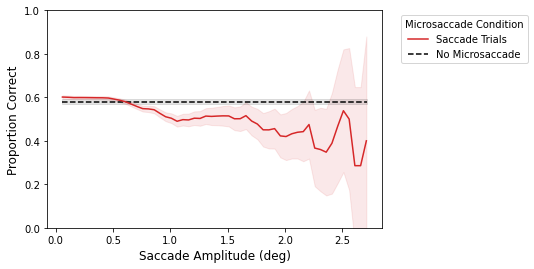

In [40]:
#Saccade Condition
df1_mean=BinnedPerfData_bySaccadeAmp_sacc.groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_bySaccadeAmp_sacc.groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_bySaccadeAmp_sacc.groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Saccade Trials',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)


#No saccade condition
df3_mean=BinnedPerfData_bySaccadeAmp_nosacc.groupby('subj_id')['corr'].mean().reset_index()
# Compute CI
df3_std=BinnedPerfData_bySaccadeAmp_nosacc.groupby('subj_id')['corr'].std().reset_index()
df3_count=BinnedPerfData_bySaccadeAmp_nosacc.groupby('subj_id')['corr'].count().reset_index()
ci3=1.96 * (df3_std['corr'])/np.sqrt(df3_count['corr']) 
xvalues=np.linspace(startPt,endPt,5)
plt.hlines(xmin=startPt,xmax=endPt,y=df3_mean['corr'].mean(),label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean['corr'].mean()+ci3.mean()),(df3_mean['corr'].mean()-ci3.mean()),color='k',alpha=0.1)

plt.legend(title='Microsaccade Condition',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_saccadeCondition_bySaccadeAmp.svg',format='svg',dpi=1200,bbox_inches='tight')